# Collections and Channels
The following sections will elaborate on the basics that are covered in this chapter. They will give examples for several of the topics covered in the Collections and Channels chapter of the book. 

## Contents
1. [Multisets](#Multisets)
    1. [Simple functorality](#Simple-functorality)
2. [Probability Distributions](#Probability-Distributions)
    1. [Biased coin distribution](#Biased-coin-distribution)
    2. [Biased dice functorality](#Biased-dice-functorality)
3. [Frequentist learning](#Frequentist-learning)
    1. [A bag of marbles](#A-bag-of-marbles)
4. [Channels](#Channels)
    1. [Biased dice with channels](#Biased-dice-with-channels)
    2. [Graphical representation of an imperfect observation](#Graphical-representation-of-an-imperfect-observation)
5. [Parallel products](#Parallel-products)
    1. [Parallel dices](#Parallel-dices)
6. [A Bayesian network example](#A-Bayesian-network-example)


## Multisets

### Simple functorality
Suppose we have a multiset containing several individuals of which we know their biological sex and age. The type of our multiset is then $\mathcal{M}(G \times A)$ where $G := \{F,M\}$ and $A := \{1,...,200\}$. Let's now take $\tau \in \mathcal{M}(G \times A)$ to be:

$$\begin{align*} 
\tau =\ &2|(F,14)\rangle + 1|(F,15)\rangle + 1|(F,17)\rangle + 3|(F,18)\rangle + 5|(F,20)\rangle + 2|(F,21)\rangle + 1|(F,23)\rangle\ +\\
&1|(M,14)\rangle + 1|(M,16)\rangle + 2|(M,17)\rangle + 1|(M,18)\rangle + 1|(M,20)\rangle + 1|(M,21)\rangle
\end{align*}$$

This $\tau$ can represent for example the participants of a cooking course for adolescents. Now we can use the projections to show how many individuals of each gender and each age take this class:

$$\begin{align*} 
\mathcal{M}(\pi_1)(\tau) &= 15|F\rangle + 7|M\rangle\\
\mathcal{M}(\pi_2)(\tau) &= 3|14\rangle + 1|15\rangle + 1|16\rangle + 3|17\rangle + 4|18\rangle + 6|20\rangle + 3|21\rangle + 1|23\rangle
\end{align*}$$

Since a multiset is functorial we can apply a function to it using $\mathcal{M}(f)(\tau)$. For example we can apply a function $next$ that 'ages' the class an entire year so that each participant now is one year older.

$$\begin{align*} 
next &:: (G\times A) \rightarrow (G\times A) \\
next((g,a)) &= (g,a+1)
\end{align*}$$

Let's apply the function as follows: $\mathcal{M}(next)(\tau)$. Pressing the button 'Next' below will apply $\mathcal{M}(next)(\tau)$ once. 

In [1]:
from efprob import *
from ipywidgets import interactive_output, Button, Output
import IPython.display as d
import nbinteract as nbi

# Technically we would need the entire set A to properly
# follow the definitions. This would however greatly increase
# the space which will make this code unnecessarily long.
# Therefore we have chosen the subset {14,...,28}.
sf_ages = [14,15,16,17,18,19,20,21,22,23,24,25,26,27,28]
sf_student_space = Space(SpaceAtom(None, ['F', 'M']), (None, sf_ages))
sf_initial_state = [2,1,0,1,3,0,5,2,0,1,0,0,0,0,0,
                     1,0,1,2,1,0,1,1,0,0,0,0,0,0,0]
sf_students = State(sf_initial_state.copy(), sf_student_space)

sf_reset = False
# def sf_chan(f, X, Y):
#     return chan_fromklmap(lambda x, y: point_state(f(x, y), Y), X, Y)

def sf_age_once(x, y):
    # Wrap around back to 14, which will never happen due to the reset
    if y == 28:
        return (x, 14)
    return (x, y+1)

sf_channel = chan_fromklmap(lambda x, y: point_state(sf_age_once(x, y), sf_student_space),
                            sf_student_space, sf_student_space)

def sf_next(button):
    global sf_students, sf_reset
    if sf_reset:
        sf_students = State(sf_initial_state.copy(), sf_student_space)
        sf_reset = False
        button.description='Next'
    else:
        sf_students = sf_channel >> sf_students
        for stud_ages in sf_students.array:
            if stud_ages[-1] > 0:
                sf_reset = True
                button.description='Reset'
                break
    sf_out.clear_output()
    with sf_out:
        d.display(nbi.bar(sf_ages, sf_students.array))
        d.display(d.Latex(r"$\tau =" + str(sf_students).replace('>',r"\rangle") + "$"))

sf_button = Button(description='Next', disabled=False)
sf_button.on_click(sf_next)
sf_out = Output()

d.display(sf_button, sf_out)
with sf_out:
    d.display(nbi.bar(sf_ages, sf_students.array))
    d.display(d.Latex(r"$\tau =" + str(sf_students).replace('>',r"\rangle") + "$"))

Button(description='Next', style=ButtonStyle())

Output()

Applying $next$ to our multiset $\tau$ only affects the age of the participants. When the button's text changes to 'Reset' pressing it will reset $\tau$ back to the value we defined at the beginning of this example.

## Probability Distributions
### Biased coin distribution
A multiset can also be generated using a function. Recall example 1.5.1 from the book, it defines a function $flip$ to parameterize a bias probability. We will use the following adaptation for $flip:[0,1]\rightarrow C$ with $C:=\{H,T\}$:

$$flip(r) := r|H\rangle + (1-r)|T\rangle$$

With this function a multiset can be generated that represents a biased coin toss. When $r$ changes, so do the chances of Heads or Tails. The following bar diagram shows the chances for either heads or tails, $r$ is changeable.

In [2]:
from efprob import *
from ipywidgets import interactive_output, FloatSlider
from IPython.display import *
import nbinteract as nbi

flip_rSlider = FloatSlider(
    value=0.51,
    min=0,
    max=1,
    step=0.01,
    description='$$r:=$$'
)

flip_options = {
    'title': 'Heads or Tails',
    'xlabel': '',
    'ylabel': 'Chance between 0 and 1 with 1 being 100%',
    'ylim': (0.00, 1.01)
}

def flip(r): return State([r, 1-r], coin_sp)

def disp_flip(_, r):
    display(Latex(r'''$$flip(''' + str(r) + ''') := ''' + str(flip(r)).replace('>',r"\rangle") + "$$"))
    return (r, 1-r)

nbi.bar(['Heads', 'Tails'], disp_flip, r=flip_rSlider, options=flip_options)

### Biased dice functorality
Let's again look at the functorality of a multiset. Suppose we have a set that represents all sides of an ordinary $6$-sided dice, $D6 := \{1, 2, 3, 4, 5, 6\}$ and recall $C := \{ H, T \}$. Then we can define the following uniform multiset for a dice using ket-notation:

$$\begin{align*} 
\varphi &= \dfrac{1}{6}|1\rangle + \dfrac{1}{6}|2\rangle + \dfrac{1}{6}|3\rangle + \dfrac{1}{6}|4\rangle + \dfrac{1}{6}|5\rangle + \dfrac{1}{6}|6\rangle
\end{align*}$$

With $\varphi \in \mathcal{M}(D6)$. Now suppose we have the following function $f$:

$$
\begin{align*} 
f &: D6 \rightarrow C  \\
f(x) &= \left\{
\begin{array}{ll}
  H\ \text{if}\ x\ \text{is even}\\
  T\ \text{otherwise}
\end{array}
\right.
\end{align*}
$$

Now since $\mathcal{M}$ is functorial we can apply $\mathcal{M}(f)(\varphi)$ as following:

$$
\begin{align*} 
    \mathcal{M}(f)(\varphi) &= \mathcal{M}(f)(\dfrac{1}{6}|1\rangle + \dfrac{1}{6}|2\rangle + \dfrac{1}{6}|3\rangle + \dfrac{1}{6}|4\rangle + \dfrac{1}{6}|5\rangle + \dfrac{1}{6}|6\rangle)\\
    &= \dfrac{1}{6}|f(1)\rangle + \dfrac{1}{6}|f(2)\rangle + \dfrac{1}{6}|f(3)\rangle + \dfrac{1}{6}|f(4)\rangle + \dfrac{1}{6}|f(5)\rangle + \dfrac{1}{6}|f(6)\rangle\\
    &= \dfrac{1}{6}|T\rangle + \dfrac{1}{6}|H\rangle + \dfrac{1}{6}|T\rangle + \dfrac{1}{6}|H\rangle + \dfrac{1}{6}|T\rangle + \dfrac{1}{6}|H\rangle\\
    &= \dfrac{3}{6}|T\rangle + \dfrac{3}{6}|H\rangle\\
    &= \dfrac{1}{2}|T\rangle + \dfrac{1}{2}|H\rangle\\
\end{align*}
$$

In this case we used the left definition of $\mathcal{M}(f)$ namely: $\mathcal{M}(\sum_i r_i|x_i\rangle)$. Suppose we have a way to accurately increase the chance of the dice to land on $6$. This can be represented by the following function $w:[0,5] \rightarrow \mathcal{M}(D6)$:

$$
w(r) = \tfrac{1-\tfrac{r}{5}}{6}|1\rangle + \tfrac{1-\tfrac{r}{5}}{6}|2\rangle + \tfrac{1-\tfrac{r}{5}}{6}|3\rangle + \tfrac{1-\tfrac{r}{5}}{6}|4\rangle + \tfrac{1-\tfrac{r}{5}}{6}|5\rangle + \tfrac{1+r}{6}|6\rangle
$$

Since the result of $w$ is an $x\in\mathcal{M}(D6)$ we can apply $\mathcal{M}(f)(x)$. This means that dependant on how weighted the dice is we have a higher change of it being even and thus a higher change to get $H$. This can be visualized as follows:

In [3]:
from efprob import *
from ipywidgets import interactive_output, FloatSlider
import IPython.display as d
import nbinteract as nbi

bdf_rSlider = FloatSlider(
    value=0.00,
    min=0,
    max=5,
    step=0.01,
    description='$$r:=$$'
)

bdf_coin_options = {
    'title': 'Chance for Heads or Tails',
    'ylabel': 'Chance between 0 and 1 with 1 being 100%',
    'ylim': (0.00, 1.01)
}

bdf_dice_options = {
    'title': 'Weighted 6-sided dice',
    'ylabel': 'Chance between 0 and 1 with 1 being 100%',
    'ylim': (0.00, 1.01)
}

# X and Y are spaces
def bdf_chan(f, X, Y):
    return chan_fromklmap(lambda x: point_state(f(x), Y), X, Y)

def bdf_observe_f(x):
    if x % 2 == 0:
        return 'H'
    return 'T'

def bdf_w(r): return State([(1-r/5)/6, (1-r/5)/6, (1-r/5)/6, (1-r/5)/6, (1-r/5)/6, (1+r)/6], pips_sp)

def bdf_disp(r):
    dice = bdf_w(r)
    coin = bdf_chan(bdf_observe_f, pips_sp, coin_sp) >> dice
    d.display(d.Latex("$w(" + str(r) + ") = " + str(dice).replace('>',r"\rangle") + "$"))
    d.display(d.Latex(r"$\mathcal{M}(f)(w(" + str(r) + ")) = " + str(coin).replace('>',r"\rangle") + "$"))

d.display(nbi.bar(['Heads', 'Tails'], (lambda _, r: (bdf_chan(bdf_observe_f, pips_sp, coin_sp) >> bdf_w(r)).array),
                  r=bdf_rSlider, options=bdf_coin_options))
d.display(nbi.bar([1,2,3,4,5,6], (lambda _, r: bdf_w(r).array), r=bdf_rSlider, options=bdf_dice_options))
d.display(interactive_output(bdf_disp, {'r': bdf_rSlider}))


Output()

## Frequentist learning
### A bag of marbles
Suppose we have a bag containing $12$ marbles where $1$ is red, $3$ are gold, $4$ are silver and $4$ are bronze. This bag is represented by the multiset: $\tau = 1|R\rangle + 3|G\rangle + 4|S\rangle + 4|B\rangle$. When we now randomly take a marble from this bag we have chance to get either a red, gold, silver or bronze one. We can compute this chance by computing $Flrn(\tau) = 0.083|R\rangle + 0.25|G\rangle + 0.33|S\rangle + 0.33|B\rangle$. However, every time we take a marble from the bag the chance for each color changes. This is illustrated below, pressing the button will take a marble from the bag according to the chances.

In [4]:
from efprob import *
from ipywidgets import Output, Button
from IPython.display import *
import nbinteract as nbi
from random import randrange

abm_marbles_sp = Space("marbles", ['R', 'G', 'S', 'B'])
abm_initial_state = [1,3,4,4]
abm_marbles = State(abm_initial_state.copy(), abm_marbles_sp)

def abm_isempty():
    all(m == 0 for m in values)

def abm_take_marble():
    indices = [[i] * int(x) for i, x in enumerate(abm_marbles.array) if x > 0]
    flat_indices = [item for sublist in indices for item in sublist]
    # Pick a random index from the flattened list and remove 1 from it
    rand_index = flat_indices[randrange(0, len(flat_indices))]
    abm_marbles.array[rand_index] = abm_marbles.array[rand_index]-1
    # We can call sp.get(rand_index)[0] here because we know that our space only contains single items
    return abm_marbles.sp.get(rand_index)[0]

def abm_do_button_pressed(button):
    global abm_marbles
    if all(n == 0 for n in abm_marbles.array):
        abm_marbles = State(abm_initial_state.copy(), abm_marbles_sp)
        button.description = 'Take a marble'
        return ""
    else:
        m = abm_take_marble()
        if all(n == 0 for n in abm_marbles.array):
            button.description = 'Put the marbles back'
        return m

abm_output = Output()

def abm_disp_bag(m):
    with abm_output:
        clear_output()
        display(Latex(r"$\tau = " + str(abm_marbles).replace('>',r"\rangle") + "$"))
        display(Latex(r"$Flrn(\tau) = " + str(abm_marbles.flrn()).replace('>',r"\rangle") + "$"))
        if not m == "":
            display("Marble taken: " + m)

def abm_button_pressed(b):
    m = abm_do_button_pressed(b)
    abm_disp_bag(m)

abm_button = Button(description='Take a marble', disabled=False)
abm_button.on_click(abm_button_pressed)

display(abm_button, abm_output)
abm_disp_bag("")

Button(description='Take a marble', style=ButtonStyle())

Output()

## Channels
### Biased dice with channels
Recall the example [Biased dice functorality](#Biased-dice-functorality) in which we used the functorality of $\mathcal{M}$ to change the fair $D6$ to a fair coin flip. This same thing can be done with channels as well. However, we will slightly change the morphism. Suppose that where the dice is rolled it is dark, and $\frac{1}{10}$ times we observe wrongly if the number is even or odd. Let's define this as a $\mathcal{D}$-channel $c$:

$$
\begin{align*} 
c &: D6\multimap\mspace{-3mu}\rightarrow C  \\
c(x) &= \left\{
\begin{array}{ll}
  \frac{1}{10}|T\rangle + \frac{9}{10}|H\rangle \ \text{if}\ x\ \text{is even}\\
  \frac{9}{10}|T\rangle + \frac{1}{10}|H\rangle\ \text{otherwise}
\end{array}
\right.
\end{align*}
$$

Now take $\omega$ to be $\frac{1}{6}|1\rangle + \frac{1}{6}|2\rangle + \frac{1}{6}|3\rangle + \frac{1}{6}|4\rangle + \frac{1}{6}|5\rangle + \frac{1}{6}|6\rangle$, then we compute $c \gg \omega$:

$$
\begin{align*} 
    c \gg \omega &= (flat \circ \mathcal{D}(c))(\omega)\\
    &= flat(\mathcal{D}(c)(\omega)) \\
    &= flat(c(\tfrac{1}{6}|1\rangle) + c(\tfrac{1}{6}|2\rangle) + c(\tfrac{1}{6}|3\rangle) + c(\tfrac{1}{6}|4\rangle) + c(\tfrac{1}{6}|5\rangle) + c(\tfrac{1}{6}|6\rangle)\\
    &= flat\left( \frac{1}{6}\left|\tfrac{9}{10}|T\rangle + \tfrac{1}{10}|H\rangle\right\rangle + \frac{1}{6}\left|\tfrac{1}{10}|T\rangle + \tfrac{9}{10}|H\rangle\right\rangle + \frac{1}{6}\left|\tfrac{9}{10}|T\rangle + \tfrac{1}{10}|H\rangle\right\rangle + \frac{1}{6}\left|\tfrac{1}{10}|T\rangle + \tfrac{9}{10}|H\rangle\right\rangle + \frac{1}{6}\left|\tfrac{9}{10}|T\rangle + \tfrac{1}{10}|H\rangle\right\rangle + \frac{1}{6}\left|\tfrac{1}{10}|T\rangle + \tfrac{9}{10}|H\rangle\right\rangle \right) \\
    &= \tfrac{3}{20}|T\rangle + \tfrac{1}{60}|H\rangle + \tfrac{1}{60}|T\rangle + \tfrac{3}{20}|H\rangle + \tfrac{3}{20}|T\rangle + \tfrac{1}{60}|H\rangle + \tfrac{1}{60}|T\rangle + \tfrac{3}{20}|H\rangle + \tfrac{3}{20}|T\rangle + \tfrac{1}{60}|H\rangle + \tfrac{1}{60}|T\rangle + \tfrac{3}{20}|H\rangle \\
    &= \tfrac{30}{60}|T\rangle + \tfrac{30}{60}|H\rangle \\
    &= \tfrac{1}{2}|T\rangle + \tfrac{1}{2}|H\rangle
\end{align*}
$$

It is visible from this calculation that even though we have an imperfect observation of whether we roll an even or an odd number in the end it doesn't matter for the final chance. However, this changes when we use a weighted dice. Recall $w$ from [Biased dice functorality](#Biased-dice-functorality), we'll use this again, but this time in combination with $c$.

In [5]:
from efprob import *
from ipywidgets import interactive_output, FloatSlider
import IPython.display as d
import nbinteract as nbi

cbd_rSlider = FloatSlider(
    value=0.00,
    min=0,
    max=5,
    step=0.01,
    description='$$r:=$$'
)

cbd_coin_options = {
    'title': 'Chance for Heads or Tails',
    'ylabel': 'Chance between 0 and 1 with 1 being 100%',
    'ylim': (0.00, 1.01)
}

cbd_dice_options = {
    'title': 'Weighted 6-sided dice',
    'ylabel': 'Chance between 0 and 1 with 1 being 100%',
    'ylim': (0.00, 1.01)
}

def cbd_function(x):
    if x % 2 == 0:
        return State([9/10, 1/10], coin_sp)
    return State([1/10,9/10], coin_sp)

cbd_channel = Channel.fromfun(cbd_function, pips_sp, coin_sp)

def cbd_w(r): return State([(1-r/5)/6, (1-r/5)/6, (1-r/5)/6, (1-r/5)/6, (1-r/5)/6, (1+r)/6], pips_sp)

def cbd_disp(r):
    dice = cbd_w(r)
    coin = cbd_channel >> dice
    d.display(d.Latex("$w(" + str(r) + ") = " + str(dice).replace('>',r"\rangle") + "$"))
    d.display(d.Latex(r"$\mathcal{M}(f)(w(" + str(r) + ")) = " + str(coin).replace('>',r"\rangle") + "$"))

d.display(nbi.bar(['Heads', 'Tails'], (lambda _, r: (cbd_channel >> cbd_w(r)).array),
                  r=cbd_rSlider, options=cbd_coin_options))
d.display(nbi.bar([1,2,3,4,5,6], (lambda _, r: cbd_w(r).array), r=cbd_rSlider, options=cbd_dice_options))
d.display(interactive_output(cbd_disp, {'r': cbd_rSlider}))

Output()

When the value of $r$ is different than $0$, i.e. the result of $w$ is no longer uniform, the imperfection in the observation matters. It will now never be the case that there is $100\%$ guarantee to get an even number or 'heads'. This is because of the way $flat$ functions. Take $w(5.0)$ which is $0|1\rangle + 0|2\rangle + 0|3\rangle + 0|4\rangle + 0|5\rangle + 1|6\rangle$ and let's compute $c \gg w(5.0)$:

$$
\begin{align*} 
    c \gg w(5.0) &= (flat \circ \mathcal{D}(c))(w(5.0))\\
    &= (flat \circ \mathcal{D}(c))(0|1\rangle + 0|2\rangle + 0|3\rangle + 0|4\rangle + 0|5\rangle + 1|6\rangle) \\
    &= flat\left(0\left|\tfrac{9}{10}|T\rangle + \tfrac{1}{10}|H\rangle\right\rangle + 0\left|\tfrac{1}{10}|T\rangle + \tfrac{9}{10}|H\rangle\right\rangle + 0\left|\tfrac{9}{10}|T\rangle + \tfrac{1}{10}|H\rangle\right\rangle + 0\left|\tfrac{1}{10}|T\rangle + \tfrac{9}{10}|H\rangle\right\rangle + 0\left|\tfrac{9}{10}|T\rangle + \tfrac{1}{10}|H\rangle\right\rangle + 1\left|\tfrac{1}{10}|T\rangle + \tfrac{9}{10}|H\rangle\right\rangle\right) \\
    &= 0\cdot\tfrac{9}{10}|T\rangle + 0\cdot\tfrac{1}{10}|H\rangle + 0\cdot\tfrac{1}{10}|T\rangle + 0\cdot\tfrac{9}{10}|H\rangle + 0\cdot\tfrac{9}{10}|T\rangle + 0\cdot\tfrac{1}{10}|H\rangle \\ &\ \ \ \ + 0\cdot\tfrac{1}{10}|T\rangle + 0\cdot\tfrac{9}{10}|H\rangle + 0\cdot\tfrac{9}{10}|T\rangle + 0\cdot\tfrac{1}{10}|H\rangle + 1\cdot\tfrac{1}{10}|T\rangle + 1\cdot\tfrac{9}{10}|H\rangle\\
    &= \tfrac{1}{10}|T\rangle + \tfrac{9}{10}|H\rangle
\end{align*}
$$

Observe how the inner probabilities are affected by the outer probabilities due to the $flat$ function. This means that since on a perfectly weighted dice we will only roll a $6$, our observation will always be $\tfrac{1}{10}|T\rangle + \tfrac{9}{10}|H\rangle$.

### Graphical representation of an imperfect observation
Recall that as stated in 1.7.1 any channel has a graphical representation as a transition graph. Let's take a channel $c$ representing an imperfect observation of a 4-sided dice with $Dice4 = \{ 1, 2, 3, 4 \}$, $C = \{ H, T \}$ with the following definition:

$$
\begin{align*} 
c &: Dice4 \times [0,10] \multimap\mspace{-3mu}\rightarrow C  \\
c(x, n) &= \left\{
\begin{array}{ll}
  \frac{n}{10}|T\rangle + \frac{10-n}{10}|H\rangle \ \text{if}\ x\ \text{is even}\\
  \frac{10-n}{10}|T\rangle + \frac{n}{10}|H\rangle\ \text{otherwise}
\end{array}
\right.
\end{align*}
$$

For this example we take the following uniform state as our dice $s = \frac{1}{4}|1\rangle + \frac{1}{4}|2\rangle + \frac{1}{4}|3\rangle + \frac{1}{4}|4\rangle \in \mathcal{D}(Dice4)$. Now let's graphically represent this channel and state while filling in $n$:

In [6]:
from IPython.display import HTML
from ipywidgets import interactive_output, IntSlider
import IPython.display as d

d4_nSlider = IntSlider(
    value=0,
    min=0,
    max=10,
    description='$$n=$$'
)

def d4_disp(x):
    paths = ""
    for side in range(1,5):
        pHeads, pTails = 0, 0
        if side % 2 == 0:
            paths += r"\path [->] (" + str(side+1) + r") edge node {" + str(int(10-x)) + r'''/10} (6);
'''
            paths += r"\path [->] (" + str(side+1) + r") edge node {" + str(int(x)) + r'''/10} (7);
'''
        else:
            paths += r"\path [->] (" + str(side+1) + r") edge node {" + str(int(10-x)) + r'''/10} (7);
'''
            paths += r"\path [->] (" + str(side+1) + r") edge node {" + str(int(x)) + r'''/10} (6);
'''
    d.display(d.HTML(r'''
<script type="text/tikz">
\usetikzlibrary{arrows.meta}
\usetikzlibrary{arrows}
\begin{tikzpicture}
    \begin{scope}[every node/.style={circle,draw,fill=black}]
        \node (1) at (0,0) {};
    \end{scope}
    
    \begin{scope}[every node/.style={circle,draw}]
        \node (2) at (3,3)  {1};
        \node (3) at (3,1)  {2};
        \node (4) at (3,-1) {3};
        \node (5) at (3,-3) {4};
        \node (6) at (10, 2) {H};
        \node (7) at (7,-2) {T};
    \end{scope}

    \begin{scope}[>={stealth[black]},
        every node/.style={fill=white,circle},
        every edge/.style={draw=black}]
        \path [->] (1) edge node {1/4} (2);
        \path [->] (1) edge node {1/4} (3);
        \path [->] (1) edge node {1/4} (4);
        \path [->] (1) edge node {1/4} (5);
''' + paths + '''
    \end{scope}
\end{tikzpicture}
</script>'''))
    
d.display(d4_nSlider)
d.display(interactive_output(d4_disp, {'x': d4_nSlider}))

IntSlider(value=0, description='$$n=$$', max=10)

Output()

## Parallel products
### Parallel dices
Suppose for some reason we want someone to roll a dice that contains $100$ possible numbers on it (i.e. the roller has a $1$ in $100$ chance for each number). Such dices exist, but in reality they take a while to land on a face since they are almost spherical. Let's say we don't have a $100$ sided dice, but we do have a $10$-sided dice, a d10. We can represent all faces on the dice as the following set $D10 := \{0,1,2,3,4,5,6,7,8,9\}$. Rolling such a dice can be represented by the following uniform probability distribution:

$$\tau = \frac{1}{10}|0\rangle + \frac{1}{10}|1\rangle + \frac{1}{10}|2\rangle + \frac{1}{10}|3\rangle + \frac{1}{10}|4\rangle + \frac{1}{10}|5\rangle + \frac{1}{10}|6\rangle + \frac{1}{10}|7\rangle + \frac{1}{10}|8\rangle + \frac{1}{10}|9\rangle$$

We now want to use this dice to create a uniform probability distribution in which every possibility has a $\frac{1}{100}$ chance. Intuitively this is easy, just roll the d10 twice and you get $100$ different combinations. In case you would like to translate this to the number sequence $[1..100]$ you can use the following:

$$ 
0, 1 = 1\\
0, 2 = 2\\
...\\
0, 9 = 9\\
0, 0 = 10\\
1, 1 = 11\\
...\\
1, 0 = 20\\
9, 0 = 100
$$

To now represent this in a multiset we can compute the parallel product of $\tau$ with itself, $\tau \otimes \tau$, as follows:

$$\begin{eqnarray*}
\tau\otimes\tau &=& \sum_{x,y} (\tau(x) \cdot \tau(y))|x,y\rangle\\
&=& (\tau(0)\cdot\tau(0))|0,0\rangle + (\tau(0)\cdot\tau(1))|0,1\rangle +\ ...\ + (\tau(9)\cdot\tau(9))|9,9\rangle\\
&=& \frac{1}{100}|0,0\rangle + \frac{1}{100}|0,1\rangle +\ ...\ + \frac{1}{100}|9,9\rangle
\end{eqnarray*}$$

## A Bayesian network example
In section 1.9 the book looks at a bayesian network (shown below) and translates this to channels. The following set of examples will show the inner workings of these channels and their influences on eachother.

In [7]:
from IPython.display import HTML

HTML(r'''
<link rel="stylesheet" type="text/css" href="http://tikzjax.com/v1/fonts.css">
<script type="text/tikz">
    \begin{tikzpicture}[
        none/.style={},
        white dot/.style={inner sep=0mm, minimum size=1.5mm, draw=black, shape=circle, text depth=-0.2mm, draw=black, fill=white},
        black dot/.style={inner sep=0mm, minimum size=1.5mm, draw=black, shape=circle, draw=black, fill=black},
        observed/.style={inner sep=0mm, minimum size=5mm, draw=black, shape=circle, text depth=-0.2mm, draw=white, tikzit draw=gray, fill=white},
        latent/.style={inner sep=0mm, minimum size=5mm, draw=black, shape=circle, text depth=-0.2mm, draw=black, fill=white},
        small box/.style={shape=rectangle, text height=1.5ex, text depth=0.25ex, yshift=0.5mm, fill=white, draw=black, minimum height=6mm, yshift=-0.5mm, minimum width=6mm, font={\Large}},
        medium box/.style={shape=rectangle, draw=black, fill=white, small box, minimum width=8mm},
        semilarge box/.style={shape=rectangle, draw=black, fill=white, small box, minimum width=12.5mm},
        large box/.style={shape=rectangle, draw=black, fill=white, small box, minimum width=15mm},
        upground/.style={circuit ee IEC, thick, ground, rotate=90, scale=1.5, inner sep=-2mm, tikzit shape=circle, tikzit fill=blue},
        downground/.style={circuit ee IEC, thick, ground, rotate=-90, scale=1.5, inner sep=-2mm, tikzit shape=circle, tikzit fill=green},
        point/.style={regular polygon, regular polygon sides=3, draw, scale=0.75, inner sep=-0.5pt, minimum width=9mm, fill=white, regular polygon rotate=180},
        copoint/.style={regular polygon, regular polygon sides=3, draw, scale=0.75, inner sep=-0.5pt, minimum width=9mm, fill=white},
        uniform/.style={point, fill=gray, tikzit shape=circle, scale=0.5},
        label/.style={font={\footnotesize}, text height=1.5ex, text depth=0.25ex, tikzit draw=blue, tikzit fill=white},
        left label/.style={label, anchor=east, xshift=2mm, tikzit draw=green, tikzit fill=white},
        right label/.style={label, anchor=west, xshift=-2mm, tikzit draw=purple, tikzit fill=white},
        disintegration/.style={draw=black, fill={gray!50}, tikzit fill=gray, shape=rectangle, minimum width=1.6cm, minimum height=1.2cm, opacity=0.3},
        empty diag/.style={shape=rectangle, draw=darkgray, dashed, minimum width=8mm, minimum height=8mm, yshift=0.5mm},
        diredge/.style={->, >=latex},
        dashed edge/.style={-, dashed}]

        \node [style=black dot] (2) at (0, -2) {};
		\node [style=semilarge box] (4) at (-1.75, 0.5) {sprinkler};
		\node [style=large box] (6) at (-1.5, 3.25) {wet grass};
		\node [style=black dot] (8) at (1.5, 1.5) {};
		\node [style=medium box] (9) at (1.5, 0) {rain};
		\node [style=medium box] (10) at (0, -3.5) {winter};
		\node [style=none] (11) at (1.5, 0.5) {};
		\node [style=none] (12) at (1.5, -0.5) {};
		\node [style=none] (13) at (-1.75, 0) {};
		\node [style=none] (14) at (2.25, 2.75) {};
		\node [style=none] (15) at (-1, 2.75) {};
		\node [style=none] (16) at (-1.75, 2.75) {};
		\node [style=none] (17) at (-1.75, 1) {};
		\node [style=none] (18) at (-1.5, 4.75) {};
		\node [style=none] (20) at (-0.5, -2.25) {$A$};
		\node [style=none] (21) at (-2.25, 1.75) {$B$};
		\node [style=none] (22) at (2, 1.25) {$C$};
		\node [style=none] (23) at (-2, 4.5) {$D$};
		\node [style=none] (24) at (2.75, 4.5) {$E$};
		\node [style=medium box] (25) at (2.25, 3.25) {slippery road};
		\node [style=none] (26) at (2.25, 4.75) {};
		\draw [style=diredge] (10) to (2);
		\draw [style=diredge, in=-90, out=45, looseness=0.75] (2) to (12.center);
		\draw [style=diredge, in=-90, out=135, looseness=0.75] (2) to (13.center);
		\draw [style=diredge] (11.center) to (8);
		\draw [style=diredge, in=-90, out=90, looseness=0.75] (17.center) to (16.center);
		\draw [style=diredge, in=-90, out=135, looseness=0.75] (8) to (15.center);
		\draw [style=diredge, in=-90, out=60, looseness=0.75] (8) to (14.center);
		\draw [style=diredge] (6) to (18.center);
		\draw [style=diredge] (25) to (26.center);
    \end{tikzpicture}
</script>
''')



As stated in the  book, this network starts with an initial state, winter. Which is defined as $wi = \tfrac{3}{5}|a\rangle + \tfrac{2}{5}|a^{\bot}$, we can then determine, because sprinkler is a channel, what the probability is that the sprinkler is on. This can be done similarly for the chance of rain. Let's now assume that we somehow have control over the winter state, i.e. the chance of it being winter. We define a function to create a different winter state: $cw(x) := \tfrac{x}{100}|a\rangle + \tfrac{100-x}{100}|a^{\bot}$. Now we can observe how this alters the different states:

In [8]:
from ipywidgets import interactive_output, IntSlider
import IPython.display as d
from efprob import *

bnea_xSlider = IntSlider(
    value=60,
    min=0,
    max=100,
    description='$$x=$$'
)

bnea_A = Space("A", ["a", r"a^{\bot}"]) # A = {a, !a}
bnea_B = Space("B", ["b", r"b^{\bot}"])
bnea_C = Space("C", ["c", r"c^{\bot}"])

def bnea_wif(x):
    return State([x/100,(100-x)/100], bnea_A)

def bnea_spf(a):
    if a == "a":
        return State([1/5, 4/5], bnea_B)
    return State([3/4,1/4], bnea_B)

bnea_sp = Channel.fromfun(bnea_spf, bnea_A, bnea_B)

def bnea_raf(a):
    if a == "a":
        return State([4/5, 1/5], bnea_C)
    return State([1/10, 9/10], bnea_C)

bnea_ra = Channel.fromfun(bnea_raf, bnea_A, bnea_C)

def bnea_disp(x):
    wi = bnea_wif(x)
    dwi = copy2(bnea_A) >> wi
    spra = bnea_sp @ bnea_ra
    d.display(d.Latex(r"$(sp \gg cw(" + str(x) + ")) =" + str(bnea_sp >> wi).replace('>',r"\rangle") + "$"))
    d.display(d.Latex(r"$(ra \gg cw(" + str(x) + ")) =" + str(bnea_ra >> wi).replace('>',r"\rangle") + "$"))
    d.display(d.Latex(r"$(sp \otimes ra) \gg (\Delta \gg cw("+ str(x) + ")) =" + str(spra >> dwi).replace('>',r"\rangle") + "$"))

d.display(interactive_output(bnea_disp, {'x': bnea_xSlider}), bnea_xSlider)

Output()

IntSlider(value=60, description='$$x=$$')

These equations should be read in a certain way. Since we have used $cw$ to control the chance of winter, we will interpret this as a condition, reading $cw(x)$ as "When there is a $x\%$ chance of winter, then..". Let's take $x=60$, then for $(sp \gg cw(60))$, it should be read as "When there is a $60\%$ of winter, then there is a $42\%$ chance that the sprinkler is activated." Next for $(ra \gg cw(60))$, it should be read as "When there is a $60\%$ of winter, then there is a $52\%$ chance that it is raining.

For the third equation, both previous equations are combined to form a parallel product. It should be read as "When there is a $60\%$ chance of winter, then the chance that the sprinkler is on and it is raining is $12.6\%$. The last part is interchangeable for all combinations of whether it is raining or the sprinkler is on. An interesting observation is that as the chance of winter increases, the chances of $b, c$ and $b^{\bot}, c^{\bot}$ converge, and the chances of $b, c^{\bot}$ and $b^{\bot}, c$ cross almost in the middle, as is visible in the graph below. Read $!x$ as $x^{\bot}$.

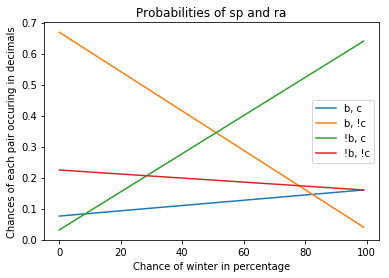

In [9]:
import IPython.display as d
from efprob import *
from matplotlib import pyplot as plt

bneg_A = Space("A", ["a", r"a^{\bot}"]) # A = {a, !a}
bneg_B = Space("B", ["b", r"b^{\bot}"])
bneg_C = Space("C", ["c", r"c^{\bot}"])

def bneg_wif(x):
    return State([x/100,(100-x)/100], bneg_A)

def bneg_spf(a):
    if a == "a":
        return State([1/5, 4/5], bneg_B)
    return State([3/4,1/4], bneg_B)

bneg_sp = Channel.fromfun(bneg_spf, bneg_A, bneg_B)

def bneg_raf(a):
    if a == "a":
        return State([4/5, 1/5], bneg_C)
    return State([1/10, 9/10], bneg_C)

bneg_ra = Channel.fromfun(bneg_raf, bneg_A, bneg_C)

def bneg_calc_at(x):
    result = (bneg_sp @ bneg_ra) >> (copy2(bneg_A) >> bneg_wif(x))
    return result.array[0][0], result.array[0][1], result.array[1][0], result.array[1][1]

def bneg_disp():
    both_line, onlyb_line, onlyc_line, none_line = [], [], [], []
    for x in range(1,101):
        both, onlyb, onlyc, none = bneg_calc_at(x)
        both_line.append(both)
        onlyb_line.append(onlyb)
        onlyc_line.append(onlyc)
        none_line.append(none)
    plt.plot(both_line, label='b, c')
    plt.plot(onlyb_line, label='b, !c')
    plt.plot(onlyc_line, label='!b, c')
    plt.plot(none_line, label='!b, !c')
    plt.title('Probabilities of sp and ra')
    plt.legend(loc = 'best')
    plt.xlabel('Chance of winter in percentage')
    plt.ylabel('Chances of each pair occuring in decimals')
    plt.show()
        
bneg_disp()

In this graph the relations between the pairs based on the chance of winter are clearly visible. Now based on the previous calculations we can finally calculate the probabilities for wet grass and slippery road.

In [10]:
from ipywidgets import interactive_output, IntSlider
import IPython.display as d
from efprob import *

bneb_xSlider = IntSlider(
    value=60,
    min=0,
    max=100,
    description='$$x=$$'
)

bneb_A = Space("A", ["a", r"a^{\bot}"]) # A = {a, !a}
bneb_B = Space("B", ["b", r"b^{\bot}"])
bneb_C = Space("C", ["c", r"c^{\bot}"])
bneb_D = Space("D", ["d", r"d^{\bot}"])
bneb_E = Space("E", ["e", r"e^{\bot}"])

def bneb_wif(x):
    return State([x/100,(100-x)/100], bnea_A)

def bneb_spf(a):
    if a == "a":
        return State([1/5, 4/5], bneb_B)
    return State([3/4,1/4], bneb_B)

bneb_sp = Channel.fromfun(bneb_spf, bneb_A, bneb_B)

def bneb_raf(a):
    if a == "a":
        return State([4/5, 1/5], bneb_C)
    return State([1/10, 9/10], bneb_C)

bneb_ra = Channel.fromfun(bneb_raf, bneb_A, bneb_C)

def bneb_srf(c):
    if c == "c":
        return State([7/10, 3/10], bneb_E)
    return State([0, 1], bneb_E)

bneb_sr = Channel.fromfun(bneb_srf, bneb_C, bneb_E)

def bneb_wgf(b, c):
    if b == "b" and c == "c":
        return State([19/20, 1/20], bneb_D)
    if b == "b" and not c == "c":
        return State([9/10, 1/10], bneb_D)
    if not b == "b" and c == "c":
        return State([4/5, 1/5], bneb_D)
    return State([0, 1], bneb_D)

bneb_wg = Channel.fromfun(bneb_wgf, bneb_B @ bneb_C, bneb_D)

def bneb_disp(x):
    wi = bneb_wif(x)
    dwi = copy2(bneb_A) >> wi
    spra = bneb_sp @ bneb_ra
    d.display(d.Latex(r"$wg \gg ((sp \otimes ra) \gg (\Delta \gg cw("+ str(x) + "))) =" + str(bneb_wg >> (spra >> dwi)).replace('>',r"\rangle") + "$"))
    d.display(d.Latex(r"$sr \gg (ra \gg cw("+ str(x) + ")) =" + str(bneb_sr >> (bneb_ra >> wi)).replace('>',r"\rangle") + "$"))

d.display(interactive_output(bneb_disp, {'x': bneb_xSlider}), bneb_xSlider)

Output()

IntSlider(value=60, description='$$x=$$')

As we increase the chance of winter we can see that the chance of a slippery road decreases quickly. This is because whether the road is slippery is dependant on if it's winter and if it's raining, if winter never occurs, then the chance of a slippery road is also small. On the contrary, the probability of wet grass doesn't change much when the chance of winter changes. This is because wet grass is dependant on two other probabilities that, as seen in the graph above, rise when the other falls and fall when the other rises. I.e. when there is less winter the sprinklers will be on more but when there is more winter there will be more rain. The graph below shows this as well.

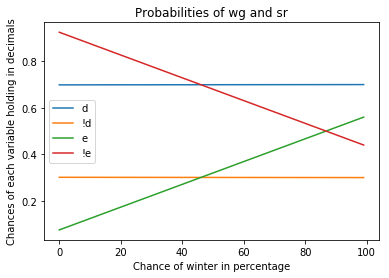

In [11]:
import IPython.display as d
from efprob import *
from matplotlib import pyplot as plt

bnebg_xSlider = IntSlider(
    value=60,
    min=0,
    max=100,
    description='$$x=$$'
)

bnebg_A = Space("A", ["a", r"a^{\bot}"]) # A = {a, !a}
bnebg_B = Space("B", ["b", r"b^{\bot}"])
bnebg_C = Space("C", ["c", r"c^{\bot}"])
bnebg_D = Space("D", ["d", r"d^{\bot}"])
bnebg_E = Space("E", ["e", r"e^{\bot}"])

def bnebg_wif(x):
    return State([x/100,(100-x)/100], bnea_A)

def bnebg_spf(a):
    if a == "a":
        return State([1/5, 4/5], bnebg_B)
    return State([3/4,1/4], bnebg_B)

bnebg_sp = Channel.fromfun(bnebg_spf, bnebg_A, bnebg_B)

def bnebg_raf(a):
    if a == "a":
        return State([4/5, 1/5], bnebg_C)
    return State([1/10, 9/10], bnebg_C)

bnebg_ra = Channel.fromfun(bnebg_raf, bnebg_A, bnebg_C)

def bnebg_srf(c):
    if c == "c":
        return State([7/10, 3/10], bnebg_E)
    return State([0, 1], bnebg_E)

bnebg_sr = Channel.fromfun(bnebg_srf, bnebg_C, bnebg_E)

def bnebg_wgf(b, c):
    if b == "b" and c == "c":
        return State([19/20, 1/20], bnebg_D)
    if b == "b" and not c == "c":
        return State([9/10, 1/10], bnebg_D)
    if not b == "b" and c == "c":
        return State([4/5, 1/5], bnebg_D)
    return State([0, 1], bnebg_D)

bnebg_wg = Channel.fromfun(bnebg_wgf, bnebg_B @ bnebg_C, bnebg_D)

def bnebg_disp():
    wi = bnebg_wif(x)
    dwi = copy2(bnebg_A) >> wi
    spra = bnebg_sp @ bnebg_ra
    d.display(d.Latex(r"$wg \gg ((sp \otimes ra) \gg (\Delta \gg cw("+ str(x) + "))) =" + str(bnebg_wg >> (spra >> dwi)).replace('>',r"\rangle") + "$"))
    d.display(d.Latex(r"$sr \gg (ra \gg cw("+ str(x) + ")) =" + str(bnebg_sr >> (bnebg_ra >> wi)).replace('>',r"\rangle") + "$"))


def bnebg_calc_at(x):
    result_wg = bnebg_wg >> (bnebg_sp @ bnebg_ra >> (copy2(bnebg_A) >> bnebg_wif(x)))
    result_sr = bnebg_sr >> (bnebg_ra >> bnebg_wif(x))
    return result_wg.array[0], result_wg.array[1], result_sr.array[0], result_sr.array[1]

def bnebg_disp():
    d_line, notd_line, e_line, note_line = [], [], [], []
    for x in range(1,101):
        d, notd, e, note = bnebg_calc_at(x)
        d_line.append(d)
        notd_line.append(notd)
        e_line.append(e)
        note_line.append(note)
    plt.plot(d_line, label='d')
    plt.plot(notd_line, label='!d')
    plt.plot(e_line, label='e')
    plt.plot(note_line, label='!e')
    plt.title('Probabilities of wg and sr')
    plt.legend(loc = 'best')
    plt.xlabel('Chance of winter in percentage')
    plt.ylabel('Chances of each variable holding in decimals')
    plt.show()
        
bnebg_disp()

For the last part of this example we combine the probabilities for wet grass and a slippery road by taking their parallel product. To ease the notation we define the following (while still using $cw(x)$ as defined before):

$$
pwg := wg \gg ((sp \otimes ra) \gg (\Delta \gg cw(x))) \\
psr := sr \gg (ra \gg cw(x))
$$

Now we calculate the parallel product.

In [12]:
from ipywidgets import interactive_output, IntSlider
import IPython.display as d
from efprob import *

bnec_xSlider = IntSlider(
    value=60,
    min=0,
    max=100,
    description='$$x=$$'
)

bnec_A = Space("A", ["a", r"a^{\bot}"]) # A = {a, !a}
bnec_B = Space("B", ["b", r"b^{\bot}"])
bnec_C = Space("C", ["c", r"c^{\bot}"])
bnec_D = Space("D", ["d", r"d^{\bot}"])
bnec_E = Space("E", ["e", r"e^{\bot}"])

def bnec_wif(x):
    return State([x/100,(100-x)/100], bnea_A)

def bnec_spf(a):
    if a == "a":
        return State([1/5, 4/5], bnec_B)
    return State([3/4,1/4], bnec_B)

bnec_sp = Channel.fromfun(bnec_spf, bnec_A, bnec_B)

def bnec_raf(a):
    if a == "a":
        return State([4/5, 1/5], bnec_C)
    return State([1/10, 9/10], bnec_C)

bnec_ra = Channel.fromfun(bnec_raf, bnec_A, bnec_C)

def bnec_srf(c):
    if c == "c":
        return State([7/10, 3/10], bnec_E)
    return State([0, 1], bnec_E)

bnec_sr = Channel.fromfun(bnec_srf, bnec_C, bnec_E)

def bnec_wgf(b, c):
    if b == "b" and c == "c":
        return State([19/20, 1/20], bnec_D)
    if b == "b" and not c == "c":
        return State([9/10, 1/10], bnec_D)
    if not b == "b" and c == "c":
        return State([4/5, 1/5], bnec_D)
    return State([0, 1], bnec_D)

bnec_wg = Channel.fromfun(bnec_wgf, bnec_B @ bnec_C, bnec_D)

def bnec_disp(x):
    wi = bnec_wif(x)
    dwi = copy2(bnec_A) >> wi
    spra = bnec_sp @ bnec_ra
    d.display(d.Latex(r"$pwg \otimes psr =" + str((bnec_wg >> (spra >> dwi)) @ (bnec_sr >> (bnec_ra >> wi))).replace('>',r"\rangle") + "$"))

d.display(interactive_output(bnec_disp, {'x': bnec_xSlider}), bnec_xSlider)

Output()

IntSlider(value=60, description='$$x=$$')

This now finally gives the probabilities for whether the grass is wet and/or the roads are slippery. What is interesting is that whether a probability in this parallel product increases or decreases is almost solely dependant on whether the probability of $e$ and $e^{\bot}$ is increasing or decreasing. This is becase as we've seen in the graph above the probability of $d$ and $d^{\bot}$ does not change. Let's visualize this again as a graph:

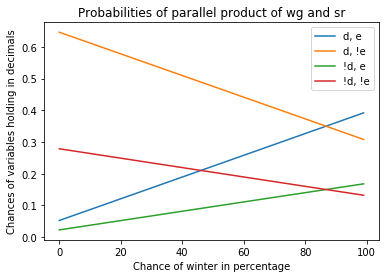

In [13]:
import IPython.display as d
from efprob import *
from matplotlib import pyplot as plt

bnecg_xSlider = IntSlider(
    value=60,
    min=0,
    max=100,
    description='$$x=$$'
)

bnecg_A = Space("A", ["a", r"a^{\bot}"]) # A = {a, !a}
bnecg_B = Space("B", ["b", r"b^{\bot}"])
bnecg_C = Space("C", ["c", r"c^{\bot}"])
bnecg_D = Space("D", ["d", r"d^{\bot}"])
bnecg_E = Space("E", ["e", r"e^{\bot}"])

def bnecg_wif(x):
    return State([x/100,(100-x)/100], bnea_A)

def bnecg_spf(a):
    if a == "a":
        return State([1/5, 4/5], bnecg_B)
    return State([3/4,1/4], bnecg_B)

bnecg_sp = Channel.fromfun(bnecg_spf, bnecg_A, bnecg_B)

def bnecg_raf(a):
    if a == "a":
        return State([4/5, 1/5], bnecg_C)
    return State([1/10, 9/10], bnecg_C)

bnecg_ra = Channel.fromfun(bnecg_raf, bnecg_A, bnecg_C)

def bnecg_srf(c):
    if c == "c":
        return State([7/10, 3/10], bnecg_E)
    return State([0, 1], bnecg_E)

bnecg_sr = Channel.fromfun(bnecg_srf, bnecg_C, bnecg_E)

def bnecg_wgf(b, c):
    if b == "b" and c == "c":
        return State([19/20, 1/20], bnecg_D)
    if b == "b" and not c == "c":
        return State([9/10, 1/10], bnecg_D)
    if not b == "b" and c == "c":
        return State([4/5, 1/5], bnecg_D)
    return State([0, 1], bnecg_D)

bnecg_wg = Channel.fromfun(bnecg_wgf, bnecg_B @ bnecg_C, bnecg_D)

def bnecg_disp():
    wi = bnecg_wif(x)
    dwi = copy2(bnecg_A) >> wi
    spra = bnecg_sp @ bnecg_ra
    d.display(d.Latex(r"$wg \gg ((sp \otimes ra) \gg (\Delta \gg cw("+ str(x) + "))) =" + str(bnecg_wg >> (spra >> dwi)).replace('>',r"\rangle") + "$"))
    d.display(d.Latex(r"$sr \gg (ra \gg cw("+ str(x) + ")) =" + str(bnecg_sr >> (bnecg_ra >> wi)).replace('>',r"\rangle") + "$"))


def bnecg_calc_at(x):
    result_wg = bnecg_wg >> (bnecg_sp @ bnecg_ra >> (copy2(bnecg_A) >> bnecg_wif(x)))
    result_sr = bnecg_sr >> (bnecg_ra >> bnecg_wif(x))
    result = result_wg @ result_sr
    return result.array[0][0], result.array[0][1], result.array[1][0], result.array[1][1]

def bnecg_disp():
    both_line, note_line, notd_line, none_line = [], [], [], []
    for x in range(1,101):
        both, note, notd, none = bnecg_calc_at(x)
        both_line.append(both)
        note_line.append(note)
        notd_line.append(notd)
        none_line.append(none)
    plt.plot(both_line, label='d, e')
    plt.plot(note_line, label='d, !e')
    plt.plot(notd_line, label='!d, e')
    plt.plot(none_line, label='!d, !e')
    plt.title('Probabilities of parallel product of wg and sr')
    plt.legend(loc = 'best')
    plt.xlabel('Chance of winter in percentage')
    plt.ylabel('Chances of variables holding in decimals')
    plt.show()
        
bnecg_disp()

This now clearly shows that as the chance of winter increases, the chances of any product containing $e$ increase, and the chances of any product containing $e^{\bot}$ decrease. Besides this, recall that in the previous graph both lines for the elements of $E$ crossed eachother at some point. In this graph they do this again but then skewed voor their own variation of $d$ or $d^{\bot}$.